In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
import scipy
import matplotlib
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import export_text

%matplotlib inline

SEED = 42
torch.manual_seed(SEED)

In [2]:
train_df = pd.read_csv('n_train.csv')
dev_df = pd.read_csv('n_dev.csv')

## Preprocessing data

In [3]:
train_size = train_df.shape[0]
dev_size = dev_df.shape[0]

In [4]:
train_size, dev_size

(429, 185)

In [5]:
df = pd.concat([train_df, dev_df])

In [6]:
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
label_col = 'Loan_Status'

In [7]:
embedding_idx_data = {'Gender': {'Male': 0, 'Female': 1},
                'Married': {'No': 2, 'Yes': 3},
                'Dependents': {'0': 4, '1': 5, '2': 6, '3+': 7 },
                'Education': {'Graduate': 8, 'Not Graduate': 9},
                'Self_Employed': {'No': 10, 'Yes': 11},
                'Credit_History': {0: 12, 1: 13},
                'Property_Area': {'Urban': 14, 'Rural': 15, 'Semiurban': 16}
               }

In [8]:
df = df.replace(embedding_idx_data)

In [9]:
df[label_col] = df[label_col].replace({-1: 0})

In [10]:
df = df[categorical_cols + numerical_cols + [label_col]]

In [11]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,0,3,6,8,10,13.0,14,2500.0,1840.0,109.0,360.0,1.0
1,0,2,4,8,10,13.0,16,5941.0,4232.0,296.0,360.0,1.0
2,0,3,7,9,10,12.0,16,4931.0,0.0,128.0,360.0,0.0
3,0,3,4,9,10,13.0,15,2894.0,2792.0,155.0,360.0,1.0
4,0,3,4,8,10,13.0,14,2500.0,3796.0,120.0,360.0,1.0


In [12]:
train_df = df.iloc[:train_size]
dev_df = df.iloc[train_size:]

assert train_df.shape[0] == train_size
assert dev_df.shape[0] == dev_size

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(train_df[numerical_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
train_df[numerical_cols] = min_max_scaler.transform(train_df[numerical_cols])
dev_df[numerical_cols] = min_max_scaler.transform(dev_df[numerical_cols])

/home/uriel/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/uriel/miniconda3/envs/ML/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/uriel/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [15]:
X_train = train_df.drop(label_col, axis=1).values
y_train = train_df[label_col].values


X_dev = dev_df.drop(label_col, axis=1).values
y_dev = dev_df[label_col].values

In [16]:
X_train = np.expand_dims(X_train, axis=-1)
X_dev = np.expand_dims(X_dev, axis=-1)

In [176]:
train_df.drop(label_col, axis=1).head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0,0,3,6,8,10,13.0,14,0.029066,0.044160,0.207900,0.74359
1,0,2,4,8,10,13.0,16,0.071626,0.101567,0.596674,0.74359
2,0,3,7,9,10,12.0,16,0.059134,0.000000,0.247401,0.74359
3,0,3,4,9,10,13.0,15,0.033939,0.067007,0.303534,0.74359
4,0,3,4,8,10,13.0,14,0.029066,0.091103,0.230769,0.74359


## Model

In [17]:
print('Examples:{}    Features:{}'.format(X_train.shape[0], X_train.shape[1]))

Examples:429    Features:11


In [18]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
                
        encoder_layers = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, ninp)
        
        self.num_embedding = nn.Linear(1, ninp)
        
        self.decoder = nn.Linear(ninp * 11, 1)
        
        self.activation = nn.Sigmoid()
        
    
    def forward(self, src):
        src_cat = self.embedding(src[:, :len(categorical_cols)].squeeze().long())
        src_num = self.num_embedding(src[:, len(categorical_cols):])
        src = torch.cat((src_cat, src_num), 1)
        src = src.transpose(0, 1)
        
        output = self.transformer_encoder(src).transpose(0, 1)
        output = torch.flatten(output, start_dim=1)
        output = self.decoder(output)
        output = self.activation(output)
        
        return output

In [19]:
num_heads = 1

model = TransformerModel(
    42, # The size of vocabulary
    3, # Embedding size 
    num_heads, # The number of heads in the multiheadattention models 
    4, # The dimension of the feedforward network model in nn.TransformerEncoder
    1, # The number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    dropout=0.2)

In [20]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).float()

X_dev = torch.Tensor(X_dev)
y_dev = torch.Tensor(y_dev).float()

In [21]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=3)

dev_dataset = TensorDataset(X_dev, y_dev)
dev_dataloader = DataLoader(dev_dataset, batch_size=3) # create your dataloader

In [22]:
EPOCHS = 50
LR = 1e-4
CHECKPOINT = 'simple_transformer.pt'

In [23]:
model.load_state_dict(torch.load(CHECKPOINT))

<All keys matched successfully>

## Attention analysis

In [24]:
model.eval()

with torch.no_grad():
    # Train
    y_train_pred = np.round(model(X_train))
    train_cm = confusion_matrix(y_train, y_train_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Validation
    y_dev_pred = np.round(model(X_dev))
    dev_cm = confusion_matrix(y_dev, y_dev_pred)
    dev_acc = accuracy_score(y_dev, y_dev_pred)

Sampling 1 example from each one of next case:

- Ground truth 0 but labeld as 0
- Ground truth 1 but labeld as 1
- Ground truth 0 but labeld as 1
- Ground truth 1 but labeld as 0

In [25]:
y_train_pred = y_train_pred.cpu().detach().numpy().flatten()

In [26]:
# GT=0, Pred=0
indices_00 = np.intersect1d(np.where(y_train == 0), np.where(y_train_pred == 0))
# GT=1, Pred=1
indices_11 = np.intersect1d(np.where(y_train == 1), np.where(y_train_pred == 1))
# GT=0, Pred=1
indices_01 = np.intersect1d(np.where(y_train == 0), np.where(y_train_pred == 1))
# GT=1, Pred=0
indices_10 = np.intersect1d(np.where(y_train == 1), np.where(y_train_pred == 0))

In [27]:
SAMPLES_PER_CATEGORY = 2

In [28]:
indices = np.concatenate((
    np.random.choice(indices_00, SAMPLES_PER_CATEGORY),
    np.random.choice(indices_10, SAMPLES_PER_CATEGORY),
    np.random.choice(indices_11, SAMPLES_PER_CATEGORY),
    np.random.choice(indices_01, SAMPLES_PER_CATEGORY)
))

In [29]:
X_analysis = X_train[indices]
y_analysis = y_train[indices]
y_analysis_pred = y_train_pred[indices]

In [30]:
src_cat = model.embedding(X_analysis[:, :len(categorical_cols)].squeeze().long())
src_num = model.num_embedding(X_analysis[:, len(categorical_cols):])
src_emb = torch.cat((src_cat, src_num), 1)

### Attention extraction

In [31]:
src = src_emb.transpose(0, 1)
attn_output, attn_output_weights = model.transformer_encoder.layers[0].self_attn(src, src, src)

In [32]:
# Attention weights
attn_weights = attn_output_weights.cpu().detach().numpy()

In [33]:
columns = df.columns[:-1].values

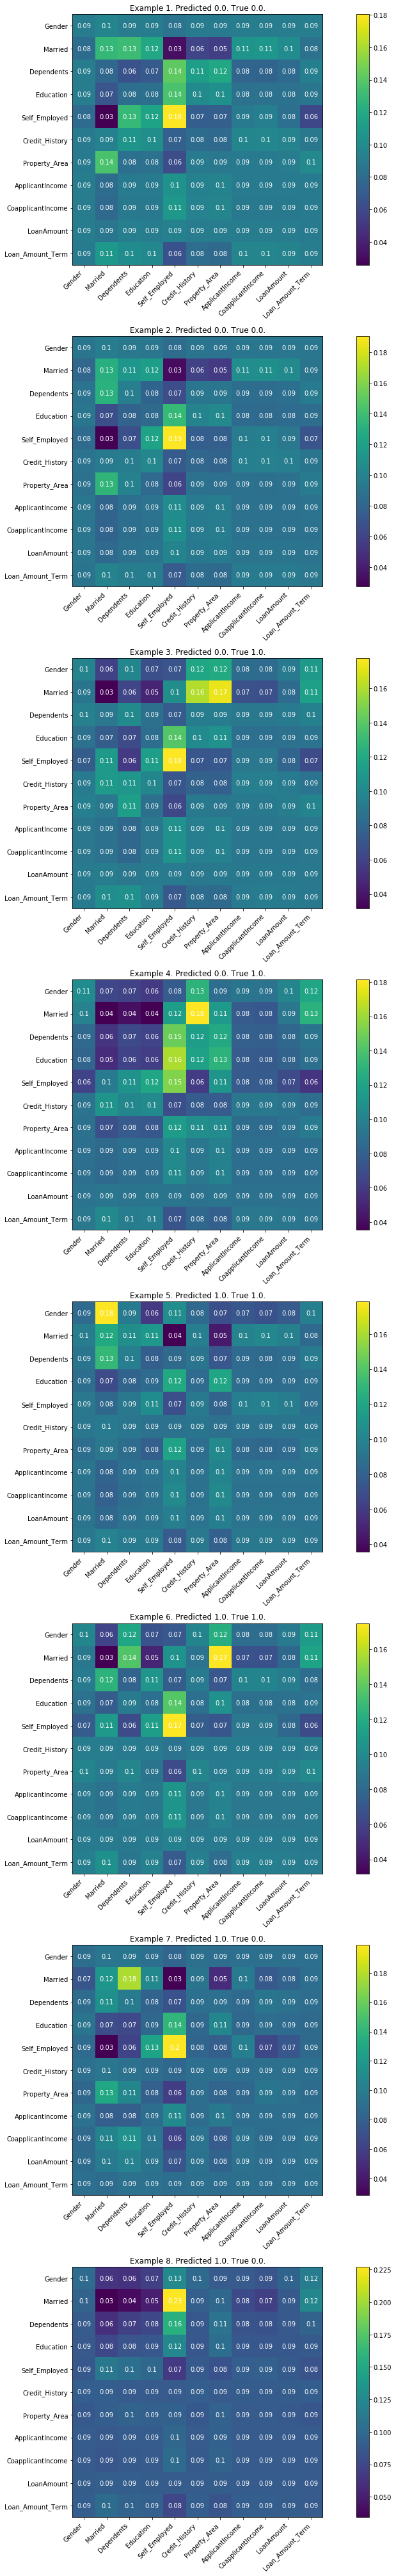

In [184]:
fig, axes = plt.subplots(attn_weights.shape[0], 1, figsize=(15, 7 * attn_weights.shape[0]))

for idx, attn_mat in enumerate(attn_weights):
    
    ax = axes[idx]
    
    im = ax.imshow(attn_mat)    
    
    ax.set_xticks(np.arange(columns.shape[0]))
    ax.set_yticks(np.arange(columns.shape[0]))
    
    ax.set_xticklabels(columns, rotation=45, ha='right')
    ax.set_yticklabels(columns)
    ax.set_title('Example {}. Predicted {}. True {}.'.format(idx + 1, y_analysis_pred[idx], y_analysis[idx]))
    ax.figure.colorbar(im, ax=ax)    
    
    for i in range(columns.shape[0]):
        for j in range(columns.shape[0]):
            text = ax.text(j, i, np.around(attn_mat[i, j], decimals=2), ha="center", va="center", color="w")
    
fig.tight_layout()

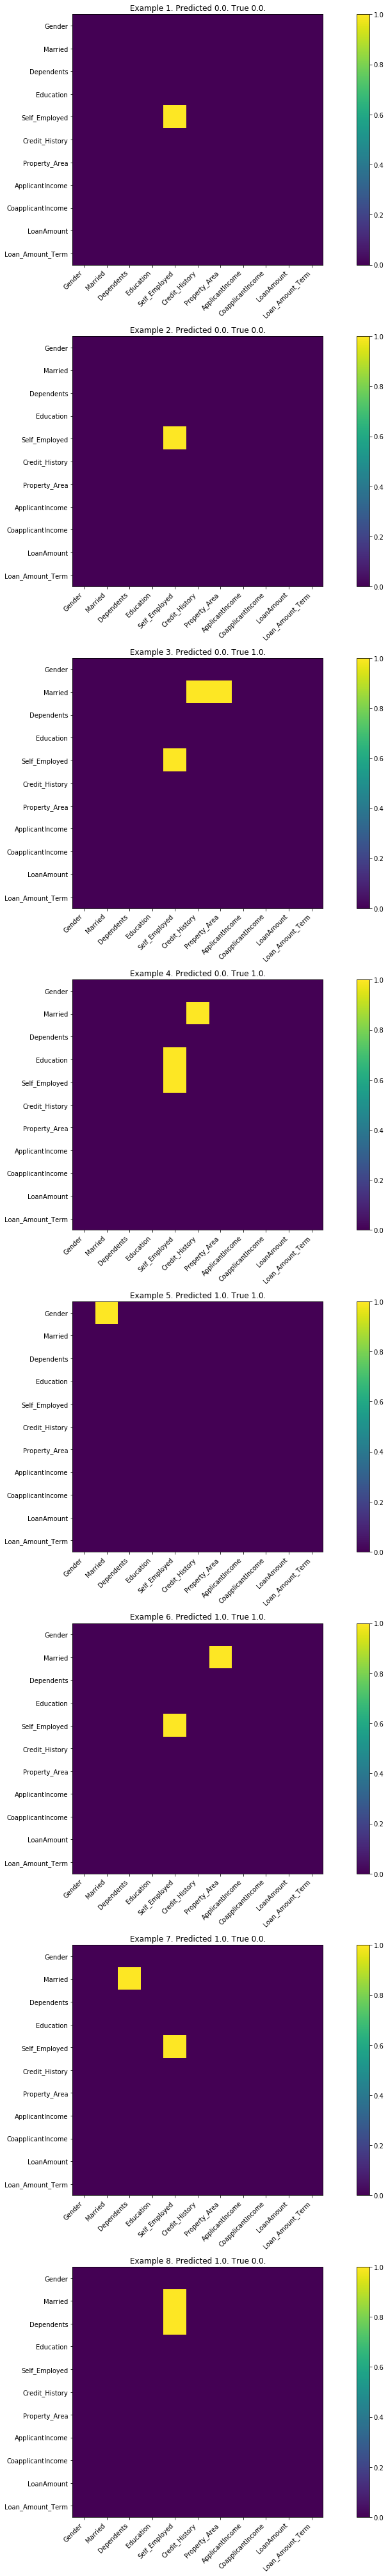

In [35]:
fig, axes = plt.subplots(attn_weights.shape[0], 1, figsize=(15, 7 * attn_weights.shape[0]))

for idx, attn_mat in enumerate(attn_weights):
    
    ax = axes[idx]
    
    im = ax.imshow((attn_mat > 0.15).astype(float))    
    
    ax.set_xticks(np.arange(columns.shape[0]))
    ax.set_yticks(np.arange(columns.shape[0]))
    
    ax.set_xticklabels(columns, rotation=45, ha='right')
    ax.set_yticklabels(columns)
    ax.set_title('Example {}. Predicted {}. True {}.'.format(idx + 1, y_analysis_pred[idx], y_analysis[idx]))
    ax.figure.colorbar(im, ax=ax)    
    
fig.tight_layout()

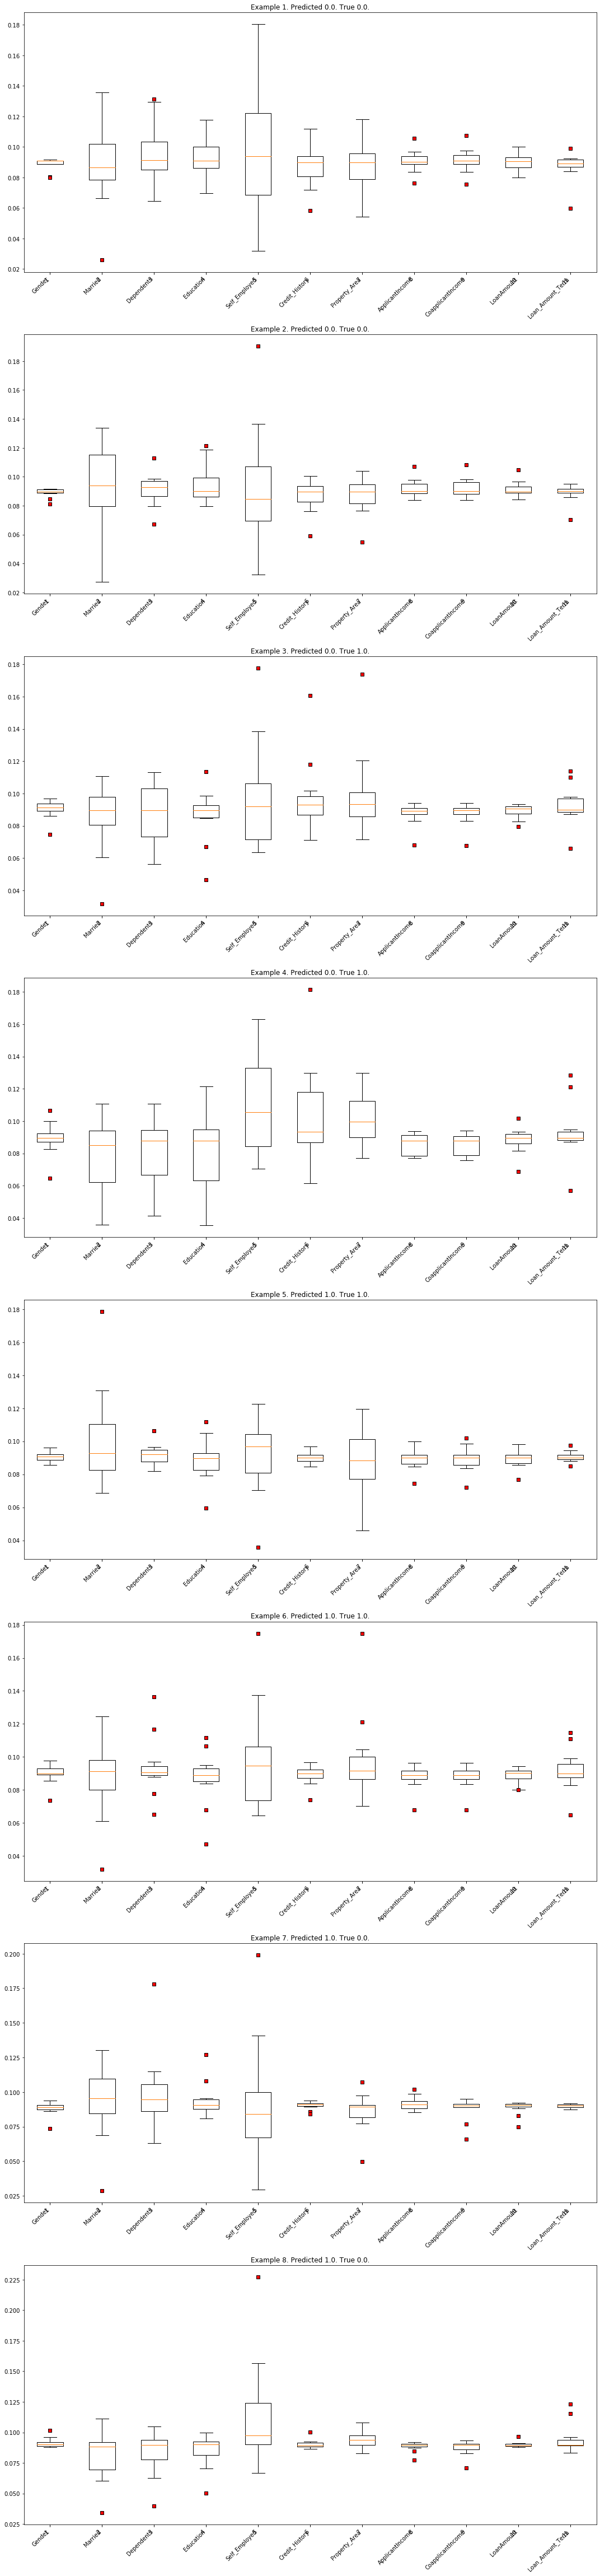

In [36]:
fig, axes = plt.subplots(attn_weights.shape[0], 1, figsize=(15, 8 * attn_weights.shape[0]))

for idx, attn_mat in enumerate(attn_weights):
    ax = axes[idx]
        
    ax.set_title('Example {}. Predicted {}. True {}.'.format(idx + 1, y_analysis_pred[idx], y_analysis[idx]))
    ax.set_xticks(np.arange(columns.shape[0]) + 1)
    ax.set_xticklabels(columns, rotation=45, ha='right')
    
    ax.boxplot(attn_mat, flierprops={'markerfacecolor':'r', 'marker':'s'})
        
fig.tight_layout()

#### Attention per class

Since the pattern is only taking a few examples, it couldn't represent the whole training dataset, so let's evaluate all examples by dividing it per class, it is, zeros and ones.

In [37]:
predicted_0_idx = np.concatenate((indices_00, indices_10), axis=0)
predicted_1_idx = np.concatenate((indices_01, indices_11), axis=0)

In [38]:
X_pred_0 = X_train[predicted_0_idx]
y_pred_0 = y_train[predicted_0_idx]

X_pred_1 = X_train[predicted_1_idx]
y_pred_1 = y_train[predicted_1_idx]

In [39]:
src_cat_pred_0 = model.embedding(X_pred_0[:, :len(categorical_cols)].squeeze().long())
src_num_pred_0 = model.num_embedding(X_pred_0[:, len(categorical_cols):])
src_emb_pred_0 = torch.cat((src_cat_pred_0, src_num_pred_0), 1)

src_pred_0 = src_emb_pred_0.transpose(0, 1)
_, attn_output_weights_pred_0 = model.transformer_encoder.layers[0].self_attn(src_pred_0, src_pred_0, src_pred_0)

attn_weights_pred_0 = attn_output_weights_pred_0.cpu().detach().numpy()

attn_weights_pred_0 = attn_weights_pred_0.sum(axis=0)
attn_weights_pred_0 = attn_weights_pred_0 / attn_weights_pred_0.sum(axis=0)

In [40]:
src_cat_pred_1 = model.embedding(X_pred_1[:, :len(categorical_cols)].squeeze().long())
src_num_pred_1 = model.num_embedding(X_pred_1[:, len(categorical_cols):])
src_emb_pred_1 = torch.cat((src_cat_pred_1, src_num_pred_1), 1)

src_pred_1 = src_emb_pred_1.transpose(0, 1)
_, attn_output_weights_pred_1 = model.transformer_encoder.layers[0].self_attn(src_pred_1, src_pred_1, src_pred_1)

attn_weights_pred_1 = attn_output_weights_pred_1.cpu().detach().numpy()

attn_weights_pred_1 = attn_weights_pred_1.sum(axis=0)
attn_weights_pred_1 = attn_weights_pred_1 / attn_weights_pred_1.sum(axis=0)

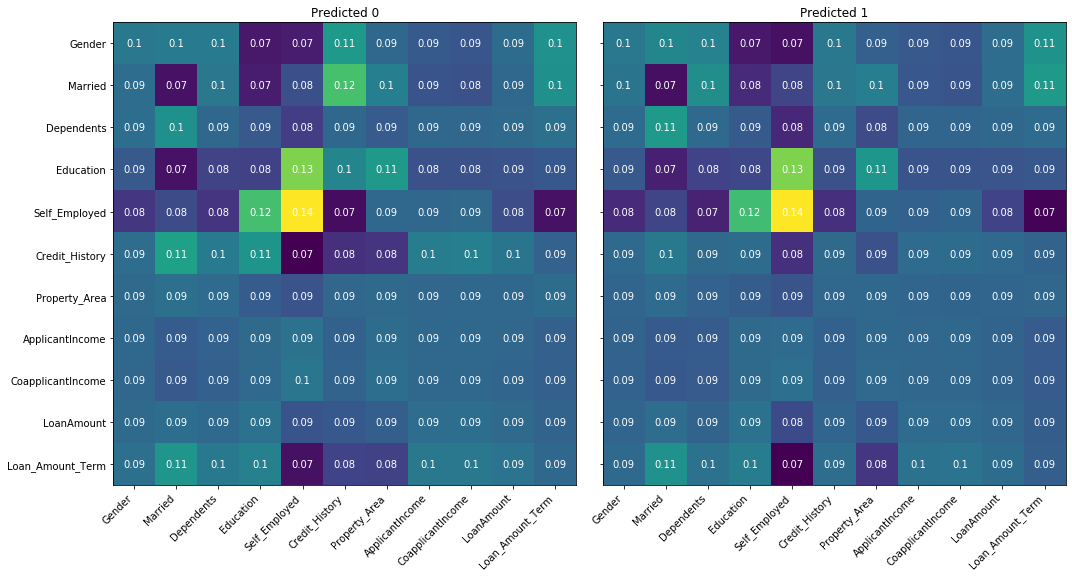

In [57]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 15), sharey=True)

# Predicted 0
im = ax_1.imshow(attn_weights_pred_0) 
ax_1.set_xticks(np.arange(columns.shape[0]))
ax_1.set_yticks(np.arange(columns.shape[0]))

ax_1.set_xticklabels(columns, rotation=45, ha='right')
ax_1.set_yticklabels(columns)
ax_1.set_title('Predicted 0')
#ax_1.figure.colorbar(im, ax=ax_1)    

for i in range(columns.shape[0]):
    for j in range(columns.shape[0]):
        text = ax_1.text(j, i, np.around(attn_weights_pred_0[i, j], decimals=2), ha="center", va="center", color="w")

        
# Predicted 1
im = ax_2.imshow(attn_weights_pred_1)  

ax_2.set_xticks(np.arange(columns.shape[0]))
ax_2.set_yticks(np.arange(columns.shape[0]))

ax_2.set_xticklabels(columns, rotation=45, ha='right')
ax_2.set_yticklabels(columns)
ax_2.set_title('Predicted 1')
#ax_2.figure.colorbar(im, ax=ax_2)    

for i in range(columns.shape[0]):
    for j in range(columns.shape[0]):
        text = ax_2.text(j, i, np.around(attn_weights_pred_1[i, j], decimals=2), ha="center", va="center", color="w")

fig.tight_layout()

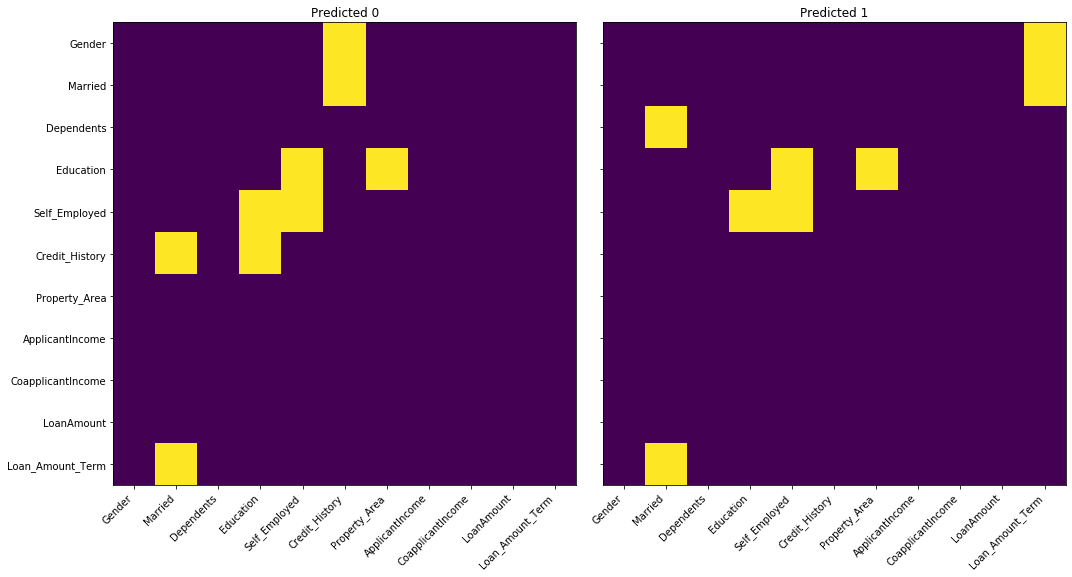

In [61]:
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 15), sharey=True)

# Predicted 0
im = ax_1.imshow((attn_weights_pred_0 > 0.105).astype(int)) 
ax_1.set_xticks(np.arange(columns.shape[0]))
ax_1.set_yticks(np.arange(columns.shape[0]))

ax_1.set_xticklabels(columns, rotation=45, ha='right')
ax_1.set_yticklabels(columns)
ax_1.set_title('Predicted 0')
        
# Predicted 1
im = ax_2.imshow((attn_weights_pred_1 > 0.105).astype(int))  

ax_2.set_xticks(np.arange(columns.shape[0]))
ax_2.set_yticks(np.arange(columns.shape[0]))

ax_2.set_xticklabels(columns, rotation=45, ha='right')
ax_2.set_yticklabels(columns)
ax_2.set_title('Predicted 1')

fig.tight_layout()

From masks above we take those features that looks important in both classes

In [196]:
attn_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 
                  'Property_Area', 'Loan_Amount_Term']

In [197]:
train_pred_0_df = df.iloc[predicted_0_idx]
train_pred_1_df = df.iloc[predicted_1_idx]

In [198]:
attn_columns_idx = np.argwhere(np.isin(df.columns.values, attn_columns) == True).squeeze()

In [201]:
clf = tree.DecisionTreeClassifier(random_state=SEED, max_depth=1)

In [202]:
X_tree_train = X_train.squeeze()[:, attn_columns_idx]
y_tree_train = y_train.squeeze()

X_tree_dev = X_dev.squeeze()[:, attn_columns_idx]
y_tree_dev = y_dev.squeeze()

In [203]:
clf = clf.fit(X_tree_train, y_tree_train)

In [204]:
y_tree_train_pred = clf.predict(X_tree_train)
y_tree_dev_pred = clf.predict(X_tree_dev)

In [205]:
# Train
train_tree_cm = confusion_matrix(y_tree_train, y_tree_train_pred)
train_tree_acc = accuracy_score(y_tree_train, y_tree_train_pred)

# Validation
dev_tree_cm = confusion_matrix(y_tree_dev, y_tree_dev_pred)
dev_tree_acc = accuracy_score(y_tree_dev, y_tree_dev_pred)

In [206]:
train_tree_cm, train_tree_acc

(array([[ 56,  78],
        [  6, 289]]),
 0.8041958041958042)

In [207]:
dev_tree_cm, dev_tree_acc

(array([[ 27,  31],
        [  3, 124]]),
 0.8162162162162162)

In [208]:
r = export_text(clf, feature_names=attn_columns)
print(r)

|--- Credit_History <= 12.50
|   |--- class: 0.0
|--- Credit_History >  12.50
|   |--- class: 1.0



### Disappointing